In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumRegister
from qiskit import QuantumCircuit
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator
from math import pi
from qiskit import *  
import tensorflow as tf
# from qutip import *
from sklearn.decomposition import PCA
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from qiskit import IBMQ

# Set this to the backend you are choosing for qiskit.
# For real IBMQ Evaluation, use a provider
backend = Aer.get_backend('qasm_simulator')


2023-08-04 16:18:32.449604: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-04 16:18:32.731715: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-04 16:18:32.733860: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 16:18:34.046130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# --------------------------------------------------
# The following section we prepare the MNIST dataset
# and normalize the dataset to be in the bound 0-1
# Following this, the data is transformed using the 
# PCA algorithm down to k dimensions 
# --------------------------------------------------
test_images,test_labels = tf.keras.datasets.mnist.load_data()
train_images = test_images[0].reshape(60000,784)
train_labels = test_images[1]
labels = test_images[1]
train_images = train_images/255

# --------------------------------------------------
# ---------------- PCA Section ---------------------
# --------------------------------------------------
k=2
pca = PCA(n_components=k)
pca.fit(train_images)
pca_data = pca.transform(train_images)[:10000]
train_labels = train_labels[:10000]
pca_descaler = [[] for _ in range(k)]

for i in range(k):
    if pca_data[:,i].min() < 0:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] += np.abs(pca_data[:,i].min())
    else:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] -= pca_data[:,i].min()
    pca_descaler[i].append(pca_data[:,i].max())
    pca_data[:,i] /= pca_data[:,i].max()

# --------------------------------------------------
# -----  Transform PCA data to rotations ----------
# --------------------------------------------------
pca_data_rot= 2*np.arcsin(np.sqrt(pca_data))    # bug why so strange expression? It doesn't give required exp val...
valid_labels = None
valid_labels = (train_labels == 3) | (train_labels == 6) | (train_labels == 9)

pca_data_rot = pca_data_rot[valid_labels]
pca_data = pca_data[valid_labels]

print(f"The Total Explained Variance of {k} Dimensions is {sum(pca.explained_variance_ratio_).round(3)}")

# --------------------------------------------------
# Define a function that can take in PCA'ed data and return an image
# --------------------------------------------------
def descale_points(d_point,scales=pca_descaler,tfrm=pca):
    for col in range(d_point.shape[1]):
        d_point[:,col] *= scales[col][1]
        d_point[:,col] += scales[col][0]
    reconstruction = tfrm.inverse_transform(d_point)
    return reconstruction

The Total Explained Variance of 2 Dimensions is 0.168


## These Functions Lead to Qubits Encoding 1 Dimension of Data
## Next Section Is For Dual Qubit Encoding

In [3]:
#All functions needed for the functionality of the circuit simulation
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      dp = np.array((predictions[i] * 127.5) + 127.5).astype('uint8')
      plt.imshow(dp)
      plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
    

    
def ran_ang():
    #return np.pi/2
    return np.random.rand()*np.pi

def single_qubit_unitary(circ_ident,qubit_index,values):
    circ_ident.ry(values[0],qubit_index)

def dual_qubit_unitary(circ_ident,qubit_1,qubit_2,values):
    circ_ident.ryy(values[0],qubit_1,qubit_2)

def controlled_dual_qubit_unitary(circ_ident,control_qubit,act_qubit,values):
    circ_ident.cry(values[0],control_qubit,act_qubit)
    #circ_ident.cry(values[0],act_qubit,control_qubit)
    
def traditional_learning_layer(circ_ident,num_qubits,values,style="Dual",qubit_start=1,qubit_end=5):
    if style == "Dual":
        for qub in np.arange(qubit_start,qubit_end):
            single_qubit_unitary(circ_ident,qub,values[str(qub)])
        for qub in np.arange(qubit_start,qubit_end-1):
            dual_qubit_unitary(circ_ident,qub,qub+1,values[str(qub)+","+str(qub+1)])
    elif style =="Single":
        for qub in np.arange(qubit_start,qubit_end):
            single_qubit_unitary(circ_ident,qub,values[str(qub)])
    elif style=="Controlled-Dual":
        for qub in np.arange(qubit_start,qubit_end):
            single_qubit_unitary(circ_ident,qub,values[str(qub)])
        for qub in np.arange(qubit_start,qubit_end-1):
            dual_qubit_unitary(circ_ident,qub,qub+1,values[str(qub)+","+str(qub+1)])
        for qub in np.arange(qubit_start,qubit_end-1):
            controlled_dual_qubit_unitary(circ_ident,qub,qub+1,values[str(qub)+"--"+str(qub+1)])

def data_loading_circuit(circ_ident,num_qubits,values,qubit_start=1,qubit_end=5):
    k = 0
    for qub in np.arange(qubit_start,qubit_end):
        circ_ident.ry(values[k],qub)
        k += 1

def swap_test(circ_ident,num_qubits):
    num_swap = num_qubits//2
    for i in range(num_swap):
        circ_ident.cswap(0,i+1,i+num_swap+1)
    circ_ident.h(0)
    circ_ident.measure(0,0)
        
def init_random_variables(q,style):
    trainable_variables = {}
    if style=="Single":
        for i in np.arange(1,q+1):
            trainable_variables[str(i)] = [ran_ang()]
    elif style=="Dual":
        for i in np.arange(1,q+1):
            trainable_variables[str(i)] = [ran_ang()]
            if i != q:
                trainable_variables[str(i)+","+str(i+1)] = [ran_ang()]
    elif style=="Controlled-Dual":
        for i in np.arange(1,q+1):
            trainable_variables[str(i)] = [ran_ang()]
            if i != q:
                trainable_variables[str(i)+","+str(i+1)] = [ran_ang()]
                trainable_variables[str(i)+"--"+str(i+1)] = [ran_ang()]
    return trainable_variables
    
def get_probabilities(circ,counts=500):
    job = execute(circ, backend, shots=counts)
    results = job.result().get_counts(circ)
    try:
        prob = results['0']/(results['1']+results['0'])
        prob = (prob-0.5)
        if prob <= 0.005:
            prob = 0.005
        else:
            prob = prob*2
    except:
        prob = 1
    return prob
        
# Define loss function. SWAP Test returns probability, so minmax probability is logical
def cost_function(p,yreal,trimming):
    if yreal == 0:
        return -np.log(p)
        #return 1-p
    elif yreal == 1:
        return -np.log(1-p)
        #return p
    
def generator_cost_function(p):
    return -np.log(p)


In [4]:
# ------------------------------------------------------------------------------------
# We treat the first n qubits are the discriminators state. n is always defined as the
# integer division floor of the qubit count.
# This is due to the fact that a state will always be k qubits, therefore the 
# number of total qubits must be 2k+1. 2k as we need k for the disc, and k to represent
# either the other learned quantum state, or k to represent a data point
# then +1 to perform the SWAP test. Therefore, we know that we will always end up
# with an odd number of qubits. We take the floor to solve for k. 1st k represents 
# disc, 2nd k represents the "loaded" state be it gen or real data
# ------------------------------------------------------------------------------------
# Use different function calls to represent training a GENERATOR or training a DISCRIMINATOR
# ------------------------------------------------------------------------------------
# THIS SECTION IS FOR THE ONLINE GENERATION OF QUANTUM CIRCUITS

def disc_fake_training_circuit(trainable_variables,key,key_value,diff=False,fwd_diff = False,Sample=False):
    if Sample:
        z = q//2
        circ = QuantumCircuit(q,z)
    else:
        circ = QuantumCircuit(q,c)
    circ.h(0)
    if diff == True and fwd_diff == True:
        trainable_variables[key][key_value] += par_shift
    if diff == True and fwd_diff == False:
        trainable_variables[key][key_value] -= par_shift
    traditional_learning_layer(circ,q,trainable_variables,style=layer_style,qubit_start=1,qubit_end=q//2 +1)
    traditional_learning_layer(circ,q,trainable_variables,style=layer_style,qubit_start=q//2 +1,qubit_end=q)
    if Sample:
        for qub in range(q//2):
            circ.measure(q//2 + 1 + qub,qub)
    else:
        swap_test(circ,q)
    if diff == True and fwd_diff == True:
        trainable_variables[key][key_value] -= par_shift
    if diff == True and fwd_diff == False:
        trainable_variables[key][key_value] += par_shift
    return circ

def disc_real_training_circuit(training_variables,data,key,key_value,diff,fwd_diff):
    circ = QuantumCircuit(q,c)
    circ.h(0)
    if diff == True & fwd_diff == True:
        training_variables[key][key_value] += par_shift
    if diff == True & fwd_diff == False:
        training_variables[key][key_value] -= par_shift
    traditional_learning_layer(circ,q,training_variables,style=layer_style,qubit_start=1,qubit_end=q//2 +1)
    data_loading_circuit(circ,q,data,qubit_start=q//2 +1,qubit_end=q)
    if diff == True & fwd_diff == True:
        training_variables[key][key_value] -= par_shift
    if diff == True & fwd_diff == False:
        training_variables[key][key_value] += par_shift
    swap_test(circ,q)
    return circ

def generate_kl_divergence_hist(actual_data, epoch_results_data):
    plt.clf() # clears current figure
    sns.set()
    kl_div_vec = []
    for kl_dim in range(actual_data.shape[1]):
        kl_div = kl_divergence(actual_data[:,kl_dim],epoch_results_data[:,kl_dim])
        kl_div_vec.append(kl_div)
    return kl_div_vec

def bin_data(dataset):
    bins = np.zeros(10)
    for point in dataset:
        indx = int(str(point).split('.')[-1][0]) # The shittest way imaginable to extract the first val aft decimal
        bins[indx] +=1  
    bins /= sum(bins)
    return bins

def kl_divergence(p_dist, q_dist):
    p = bin_data(p_dist)
    q = bin_data(q_dist)
    kldiv = 0
    for p_point,q_point in zip(p,q):
        kldiv += (np.sqrt(p_point) - np.sqrt(q_point))**2
    kldiv = (1/np.sqrt(2))*kldiv**0.5 
    return kldiv
    #return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))  # ?... are we confident in this... 

    
# Checkpointing code
def save_variables(var_dict,epoch):
    with open(f"Epoch-{epoch}-Variables-numbers-9",'w') as file:
        file.write(str(train_var))

Starting Training
--------------------


Generator Loss: 0.16588989322504263
Discriminator Loss: 3.4295968561838523
--------------------


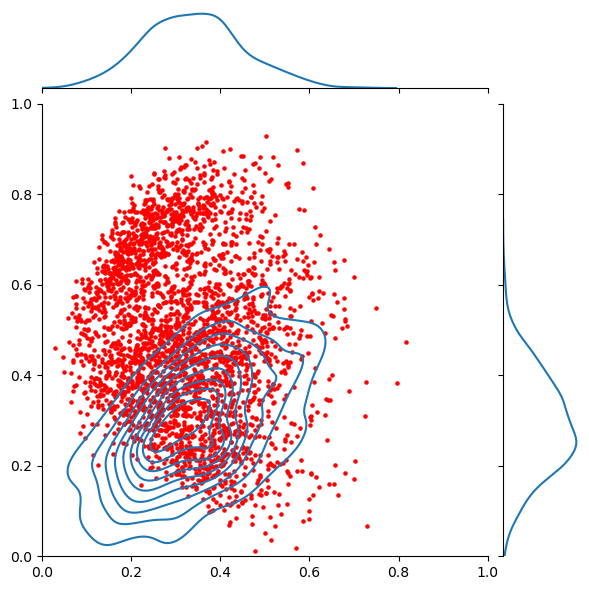

[0.16707037223589566, 0.4304938396051285]
[0.2987821059205121]
Epoch 1 Generated Images


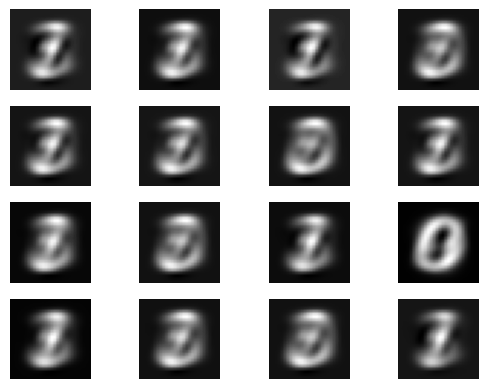

Generator Loss: 0.024546066465986536
Discriminator Loss: 4.476249405921251
--------------------


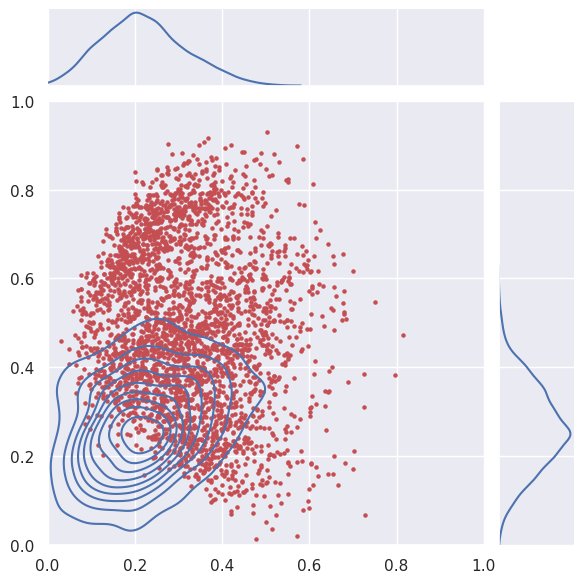

[0.2548667311196263, 0.5135432044645855]
[0.2987821059205121, 0.3842049677921059]
Epoch 2 Generated Images


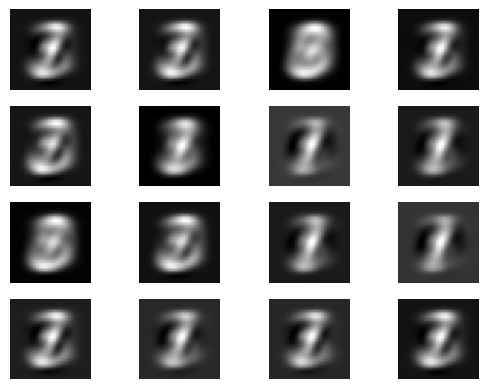

Generator Loss: 0.00791868845959602
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


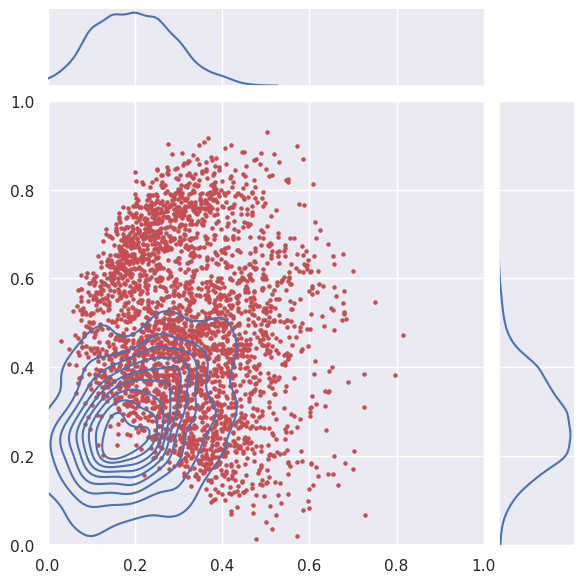

[0.3299753125463467, 0.47067497043390927]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128]
Epoch 3 Generated Images


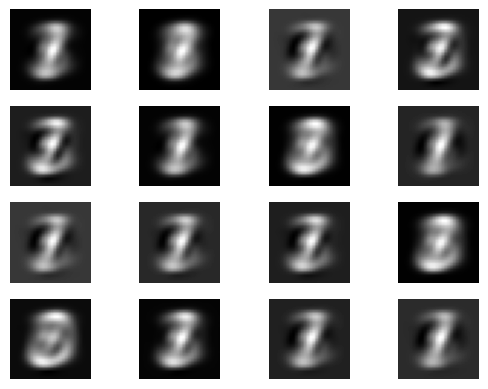

Generator Loss: 0.0034854065394629282
Discriminator Loss: 5.58760072036679
--------------------


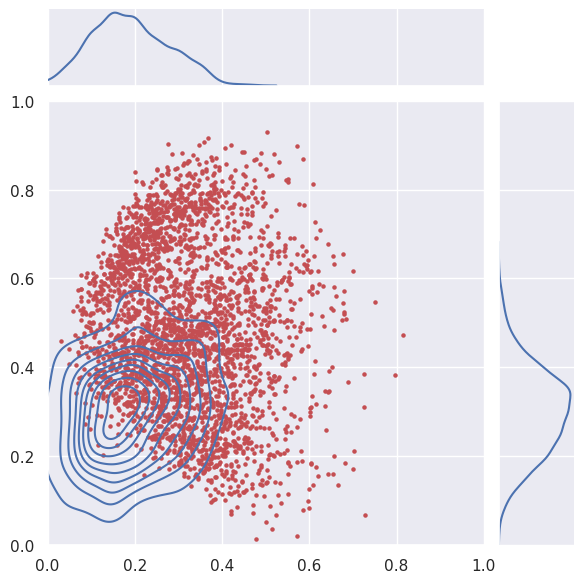

[0.3668072049648321, 0.44985070303915153]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918]
Epoch 4 Generated Images


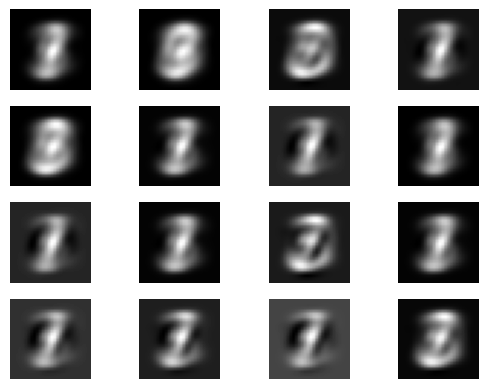

Generator Loss: 0.0018329232590221017
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


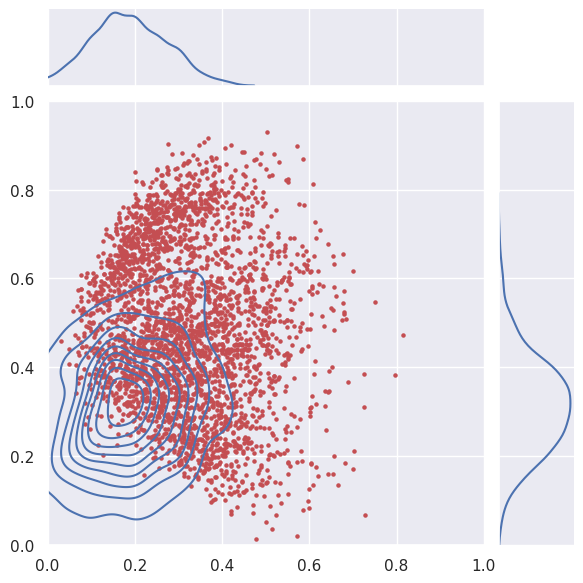

[0.36311833287177603, 0.3793787478536546]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153]
Epoch 5 Generated Images


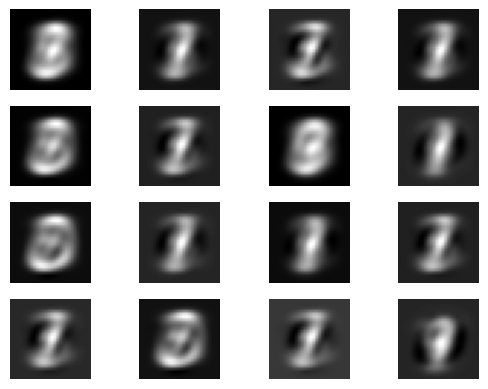

Generator Loss: 0.0013281211600275954
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


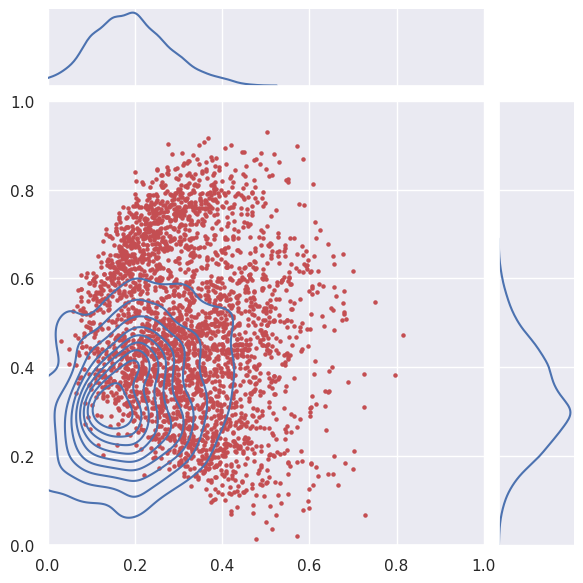

[0.3483217611150369, 0.3977644315976144]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256]
Epoch 6 Generated Images


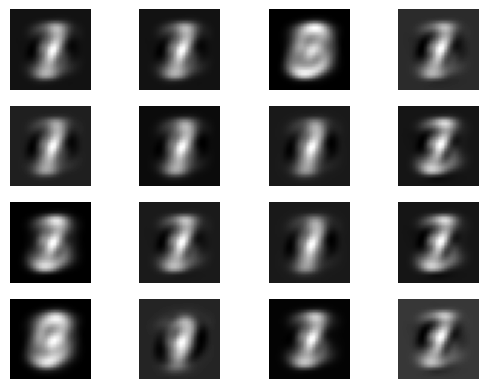

Generator Loss: 0.0007835051420846446
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


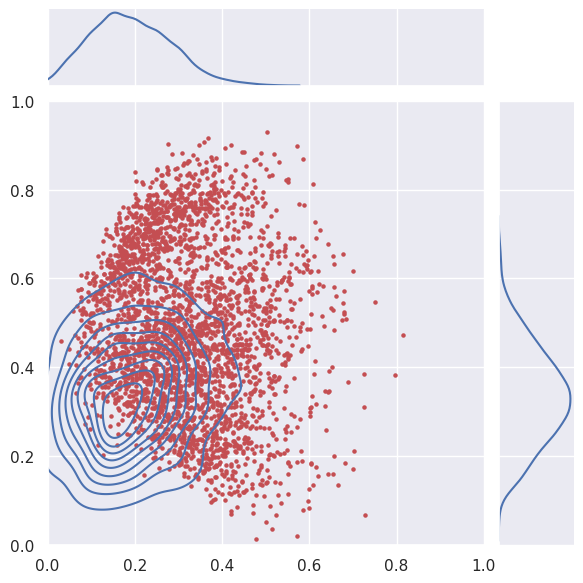

[0.33367513908884394, 0.3847746108080614]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527]
Epoch 7 Generated Images


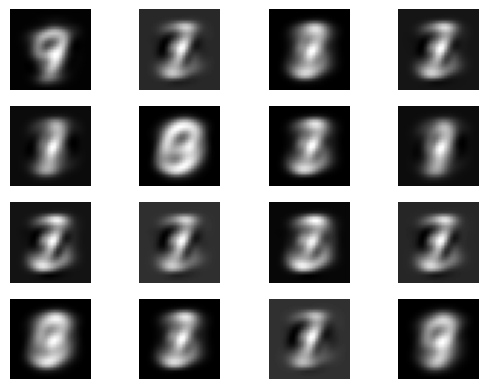

/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)
/tmp/ipykernel_284309/1791456084.py:48: RuntimeWarning: invalid value encountered in scalar divide
  df = df/abs(df)


Generator Loss: 0.0005973285453431128
Discriminator Loss: inf
--------------------


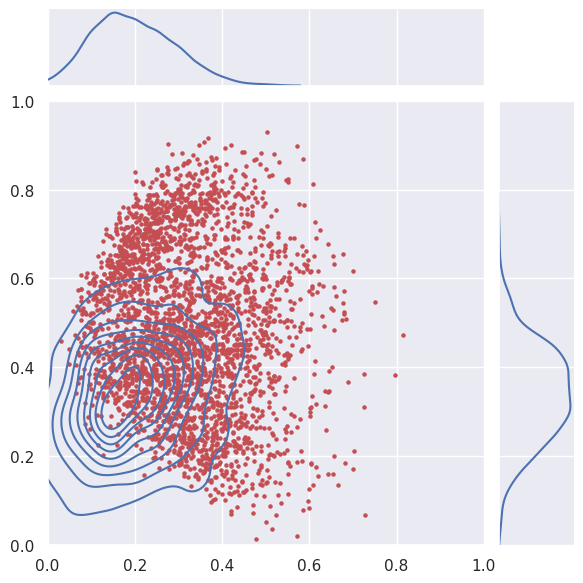

[0.31134668624044715, 0.3693544222093732]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102]
Epoch 8 Generated Images


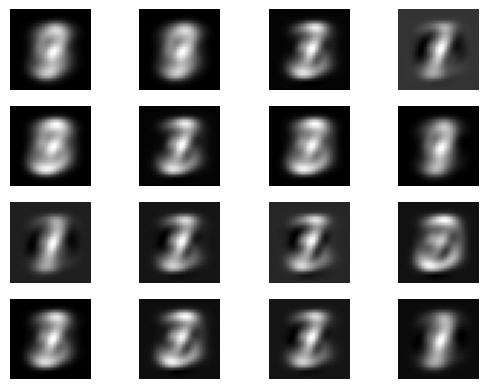

Generator Loss: 0.0006771183304152746
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


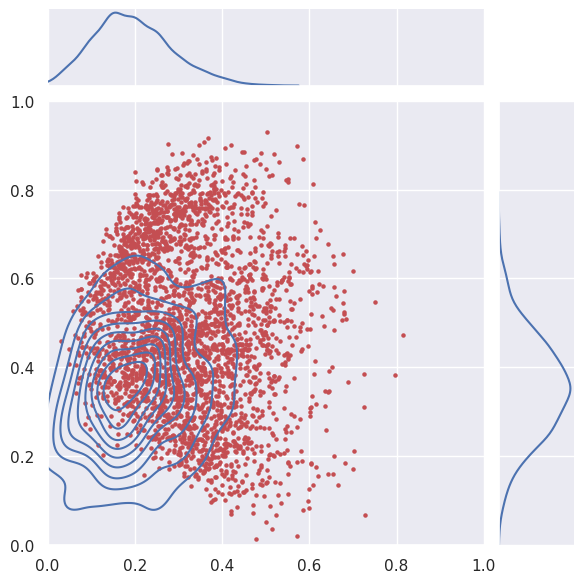

[0.3290718945308316, 0.33401182429194615]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886]
Epoch 9 Generated Images


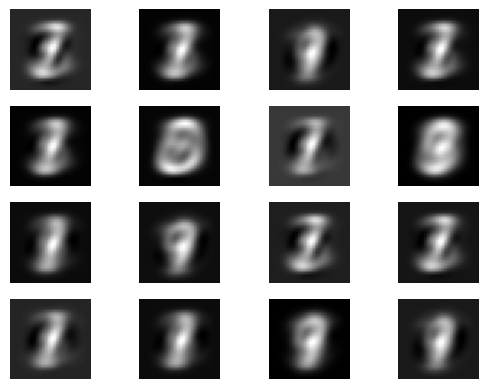

Generator Loss: 0.0004115262289009163
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


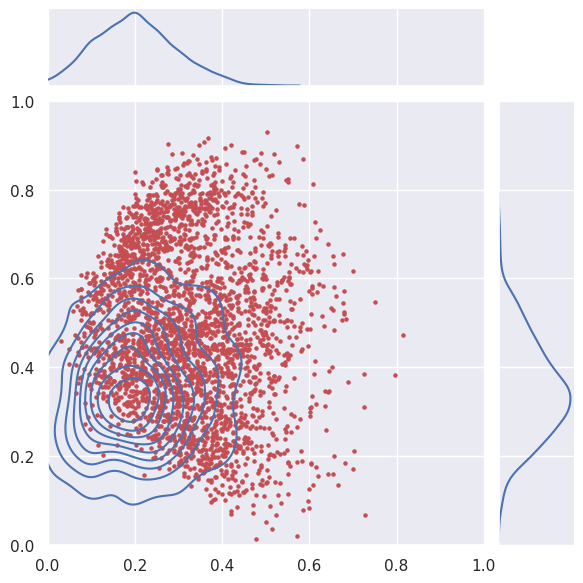

[0.3073133628365997, 0.35373949661116044]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801]
Epoch 10 Generated Images


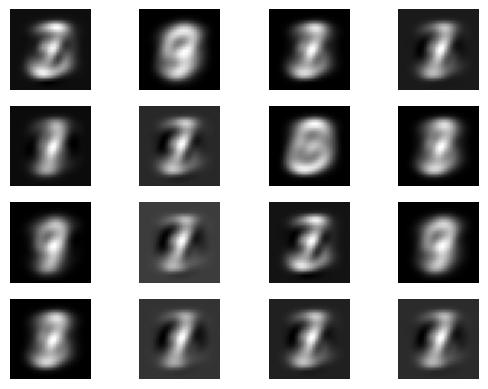

Generator Loss: 0.00035838644581369144
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


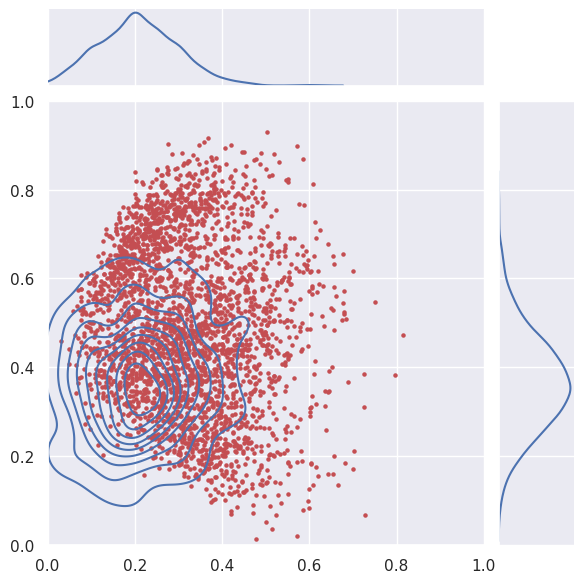

[0.30436813540528135, 0.33912477681306413]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274]
Epoch 11 Generated Images


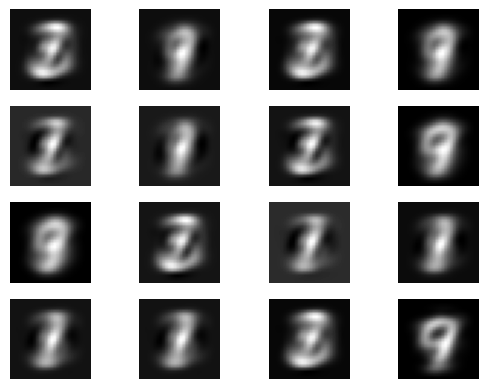

Generator Loss: 0.00030524666272646654
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


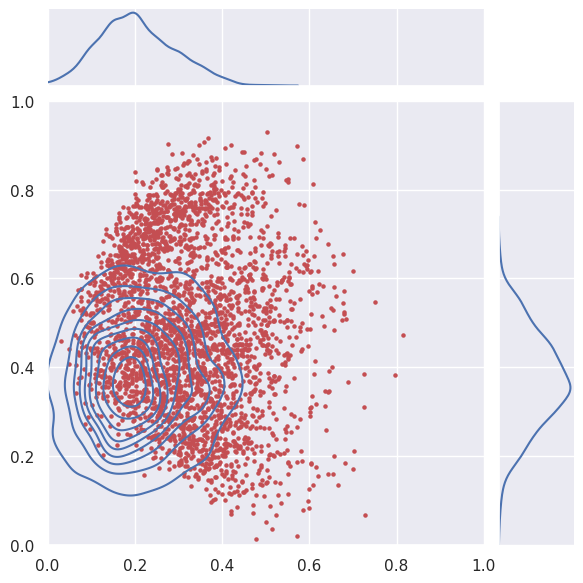

[0.3067607766144751, 0.36881397711070363]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936]
Epoch 12 Generated Images


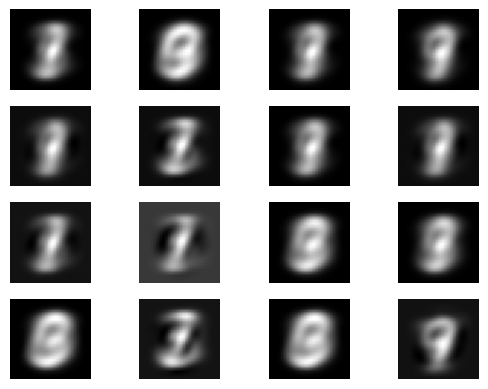

Generator Loss: 0.00013271594031585504
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


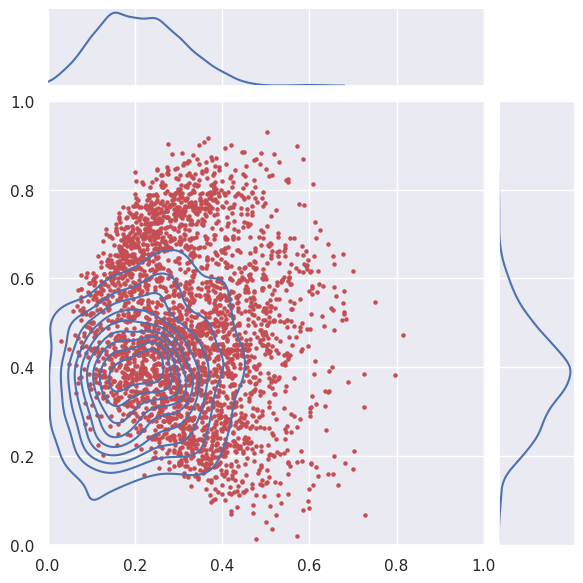

[0.2905647956314041, 0.33426810006578056]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936, 0.31241644784859235]
Epoch 13 Generated Images


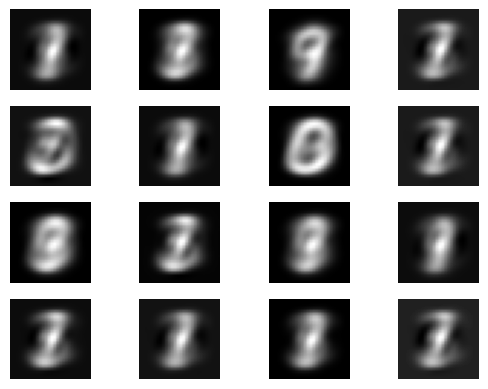

Generator Loss: 0.00013271594031585504
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


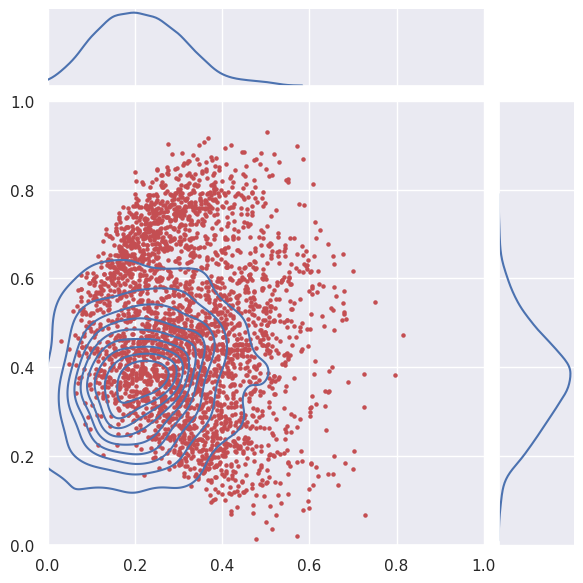

[0.2653907430098257, 0.33893102944107156]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936, 0.31241644784859235, 0.3021608862254486]
Epoch 14 Generated Images


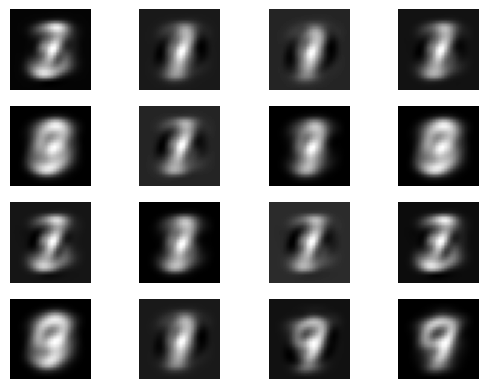

Generator Loss: 0.00011944434628426952
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


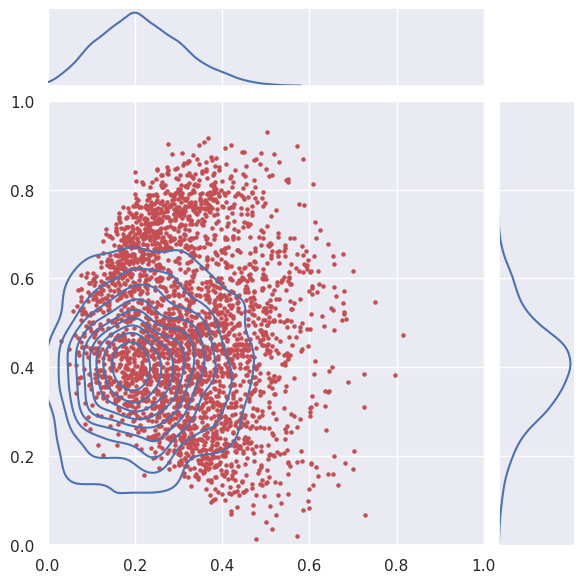

[0.26147424960873145, 0.3360448544636159]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936, 0.31241644784859235, 0.3021608862254486, 0.29875955203617366]
Epoch 15 Generated Images


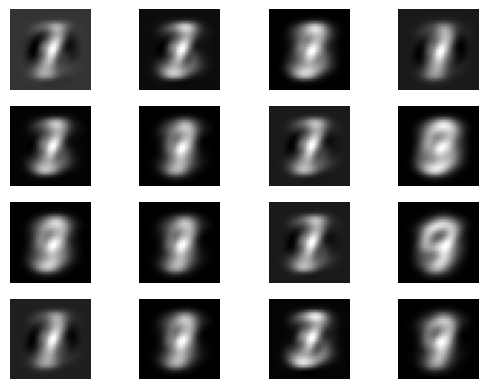

Generator Loss: 5.308637612634201e-05
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


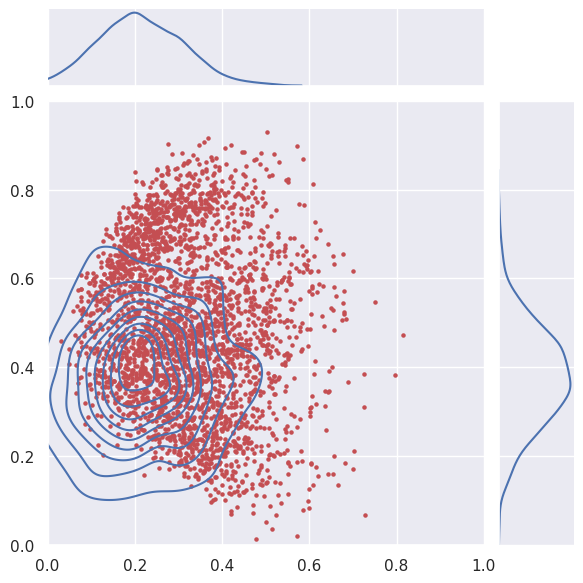

[0.26677822123955597, 0.312078305553299]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936, 0.31241644784859235, 0.3021608862254486, 0.29875955203617366, 0.28942826339642747]
Epoch 16 Generated Images


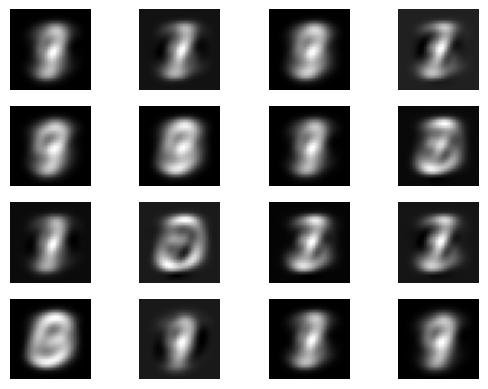

Generator Loss: 0.00019907391047378255
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


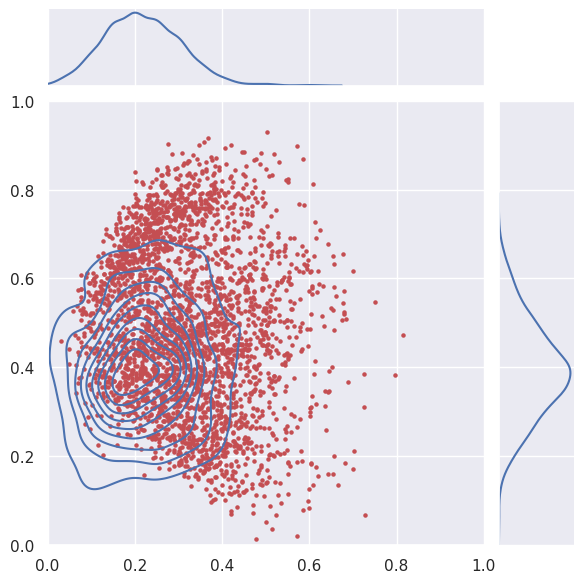

[0.26754047464292324, 0.31618198194615815]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936, 0.31241644784859235, 0.3021608862254486, 0.29875955203617366, 0.28942826339642747, 0.2918612282945407]
Epoch 17 Generated Images


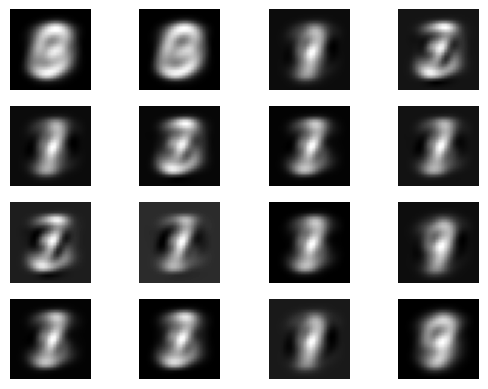

/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)
/tmp/ipykernel_284309/1791456084.py:46: RuntimeWarning: invalid value encountered in scalar subtract
  df = 0.5*(forward_diff-backward_diff)


Generator Loss: 9.290115822109852e-05
Discriminator Loss: inf
--------------------


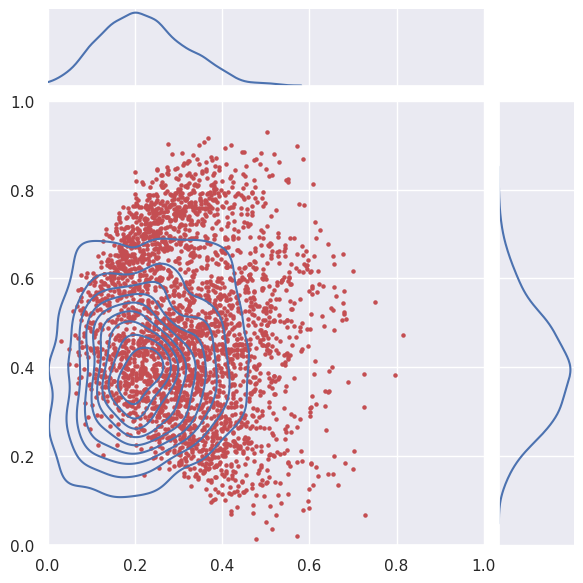

[0.25008528716178413, 0.2719498160576539]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936, 0.31241644784859235, 0.3021608862254486, 0.29875955203617366, 0.28942826339642747, 0.2918612282945407, 0.261017551609719]
Epoch 18 Generated Images


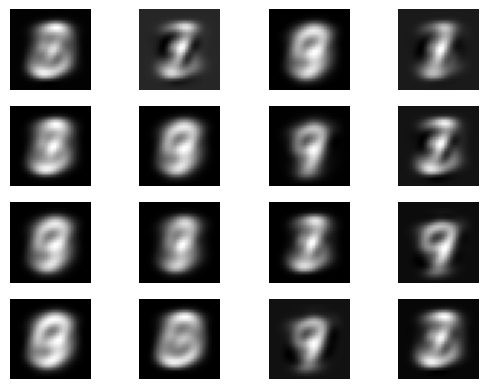

/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)
/tmp/ipykernel_284309/1791456084.py:48: RuntimeWarning: invalid value encountered in scalar divide
  df = df/abs(df)


Generator Loss: 6.635797015792752e-05
Discriminator Loss: inf
--------------------


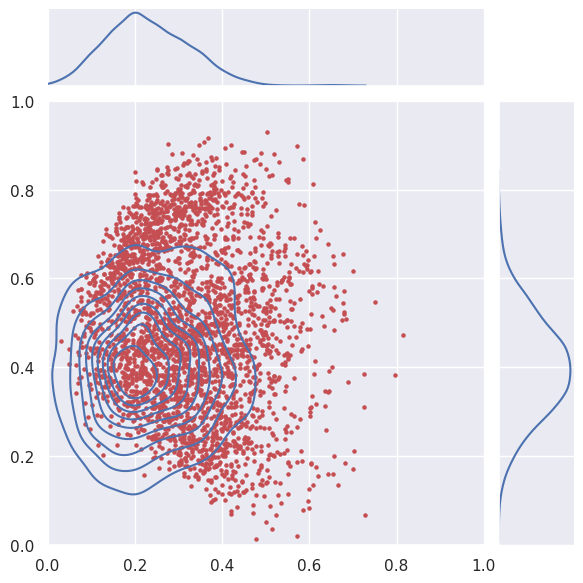

[0.23597921044328551, 0.29883554012717317]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936, 0.31241644784859235, 0.3021608862254486, 0.29875955203617366, 0.28942826339642747, 0.2918612282945407, 0.261017551609719, 0.26740737528522934]
Epoch 19 Generated Images


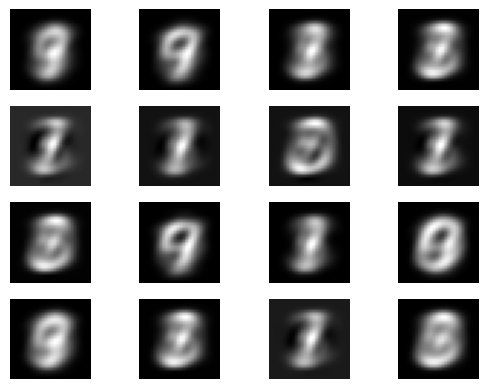

/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)
/tmp/ipykernel_284309/1791456084.py:46: RuntimeWarning: invalid value encountered in scalar subtract
  df = 0.5*(forward_diff-backward_diff)


Generator Loss: 7.962956418951301e-05
Discriminator Loss: inf
--------------------


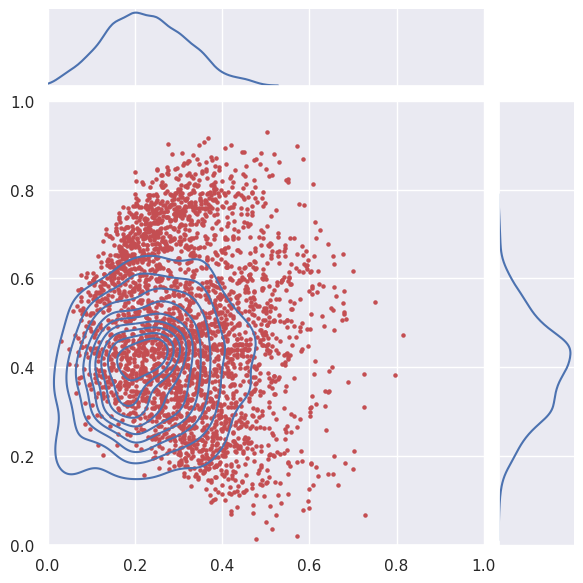

[0.27523993957752957, 0.3271964272168423]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936, 0.31241644784859235, 0.3021608862254486, 0.29875955203617366, 0.28942826339642747, 0.2918612282945407, 0.261017551609719, 0.26740737528522934, 0.3012181833971859]
Epoch 20 Generated Images


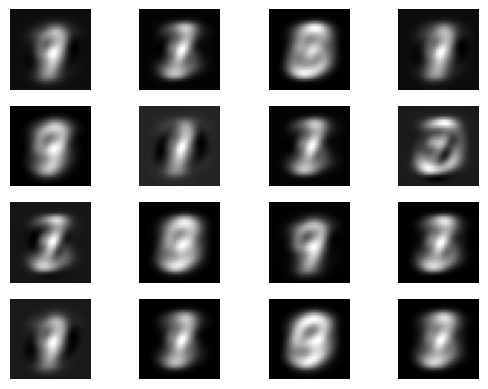

/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)
/tmp/ipykernel_284309/1791456084.py:48: RuntimeWarning: invalid value encountered in scalar divide
  df = df/abs(df)


Generator Loss: 5.308637612634201e-05
Discriminator Loss: inf
--------------------


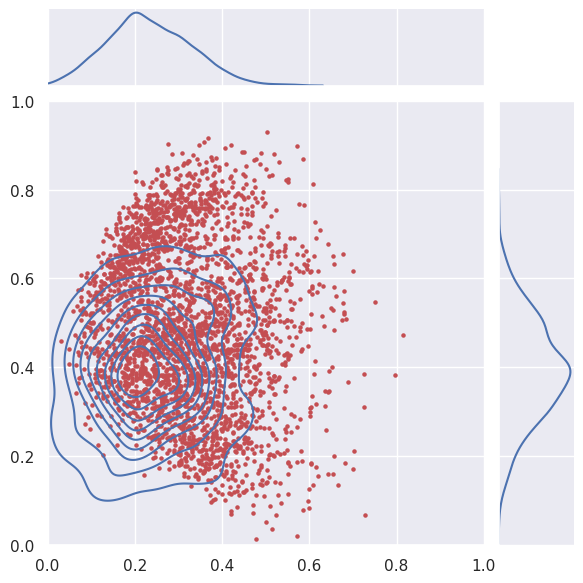

[0.22262319637922326, 0.3054363479115773]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936, 0.31241644784859235, 0.3021608862254486, 0.29875955203617366, 0.28942826339642747, 0.2918612282945407, 0.261017551609719, 0.26740737528522934, 0.3012181833971859, 0.2640297721454003]
Epoch 21 Generated Images


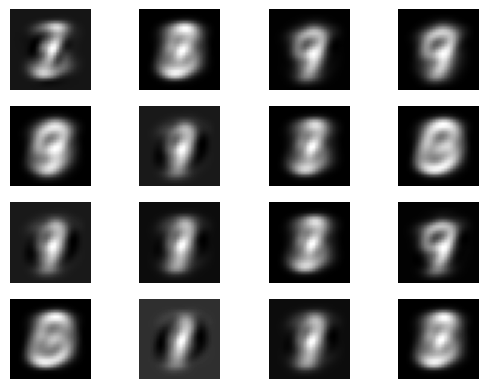

Generator Loss: 2.6543188063171006e-05
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


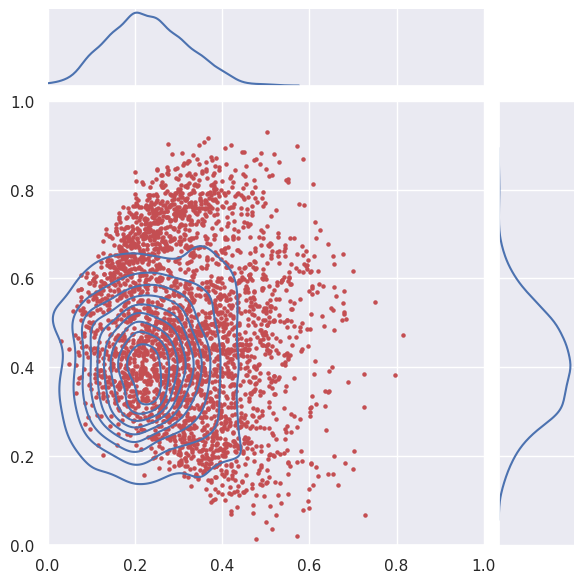

[0.24880700024695362, 0.32614450093922653]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936, 0.31241644784859235, 0.3021608862254486, 0.29875955203617366, 0.28942826339642747, 0.2918612282945407, 0.261017551609719, 0.26740737528522934, 0.3012181833971859, 0.2640297721454003, 0.28747575059309005]
Epoch 22 Generated Images


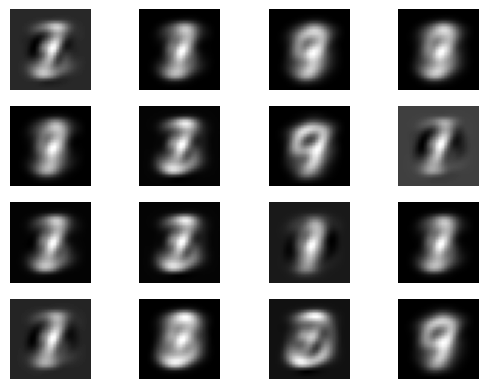

/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)
/tmp/ipykernel_284309/1791456084.py:48: RuntimeWarning: invalid value encountered in scalar divide
  df = df/abs(df)


Generator Loss: 5.308637612634201e-05
Discriminator Loss: inf
--------------------


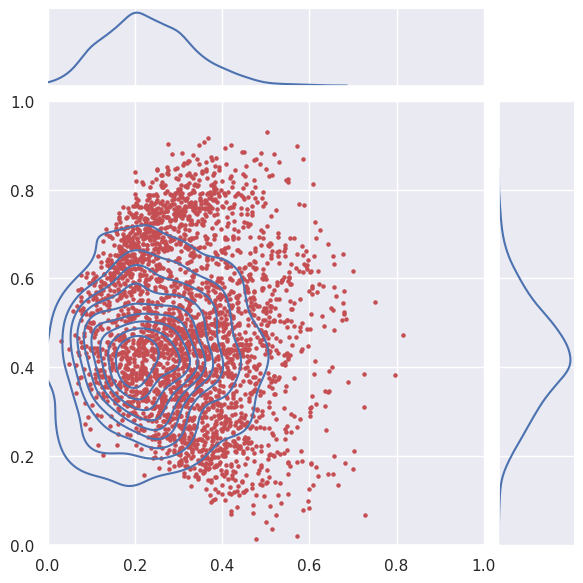

[0.20141978710346026, 0.28505393550083113]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936, 0.31241644784859235, 0.3021608862254486, 0.29875955203617366, 0.28942826339642747, 0.2918612282945407, 0.261017551609719, 0.26740737528522934, 0.3012181833971859, 0.2640297721454003, 0.28747575059309005, 0.2432368613021457]
Epoch 23 Generated Images


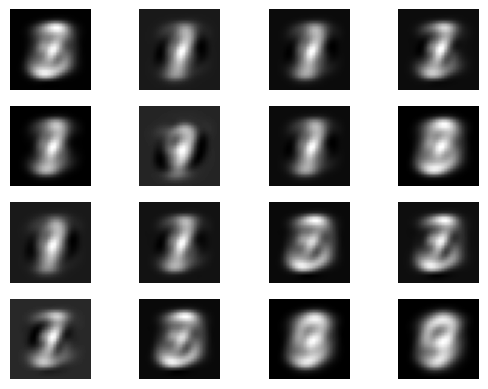

Generator Loss: 9.290115822109852e-05
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


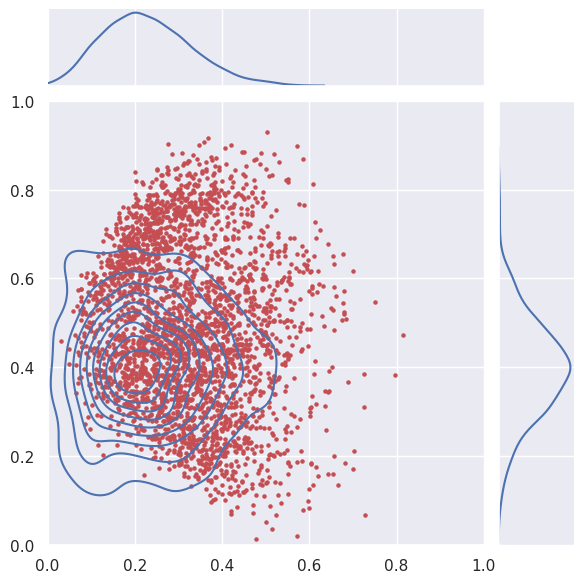

[0.2205068686508342, 0.29028528667851283]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936, 0.31241644784859235, 0.3021608862254486, 0.29875955203617366, 0.28942826339642747, 0.2918612282945407, 0.261017551609719, 0.26740737528522934, 0.3012181833971859, 0.2640297721454003, 0.28747575059309005, 0.2432368613021457, 0.25539607766467354]
Epoch 24 Generated Images


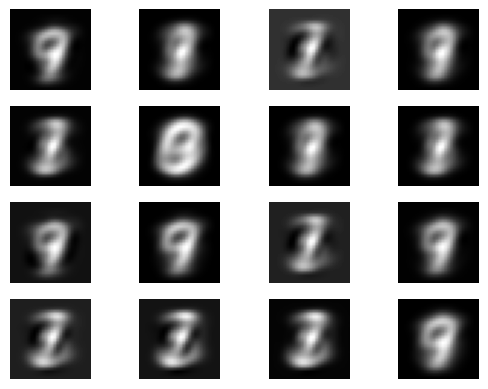

Generator Loss: 9.295456518198137e-05
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


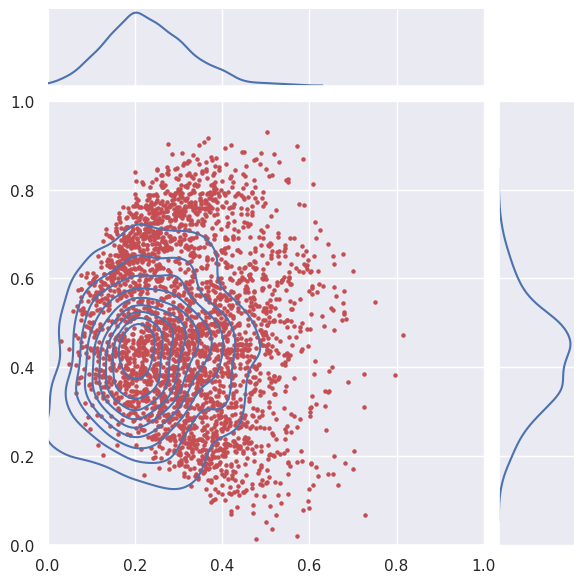

[0.2262368057783968, 0.2822975462989558]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936, 0.31241644784859235, 0.3021608862254486, 0.29875955203617366, 0.28942826339642747, 0.2918612282945407, 0.261017551609719, 0.26740737528522934, 0.3012181833971859, 0.2640297721454003, 0.28747575059309005, 0.2432368613021457, 0.25539607766467354, 0.2542671760386763]
Epoch 25 Generated Images


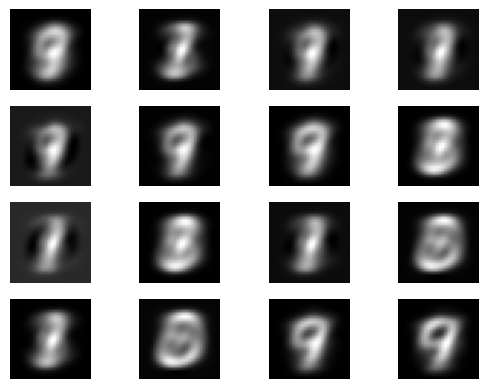

Generator Loss: 1.3271594031585503e-05
Discriminator Loss: inf
--------------------


/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)


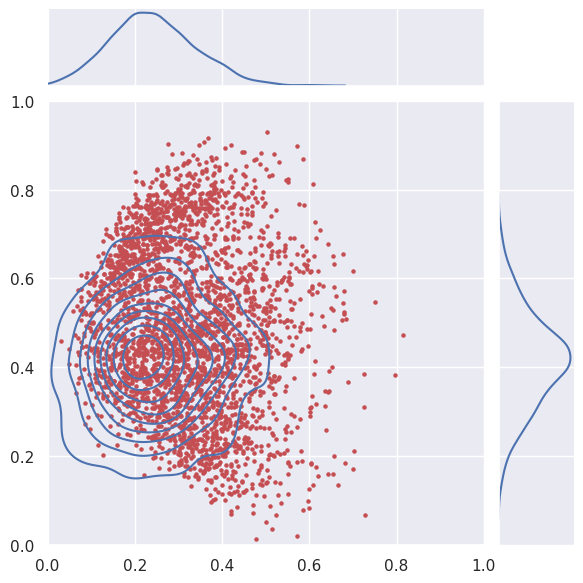

[0.1898051041074561, 0.3025845273222143]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936, 0.31241644784859235, 0.3021608862254486, 0.29875955203617366, 0.28942826339642747, 0.2918612282945407, 0.261017551609719, 0.26740737528522934, 0.3012181833971859, 0.2640297721454003, 0.28747575059309005, 0.2432368613021457, 0.25539607766467354, 0.2542671760386763, 0.2461948157148352]
Epoch 26 Generated Images


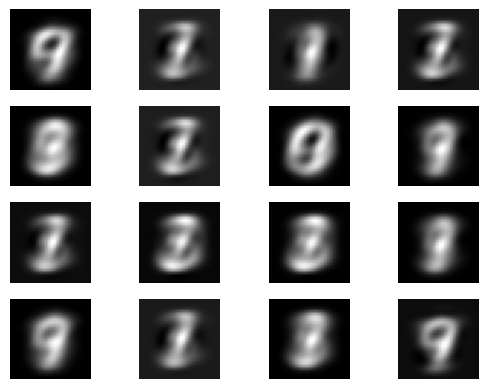

/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)
/tmp/ipykernel_284309/1791456084.py:48: RuntimeWarning: invalid value encountered in scalar divide
  df = df/abs(df)


Generator Loss: 7.962956418951301e-05
Discriminator Loss: inf
--------------------


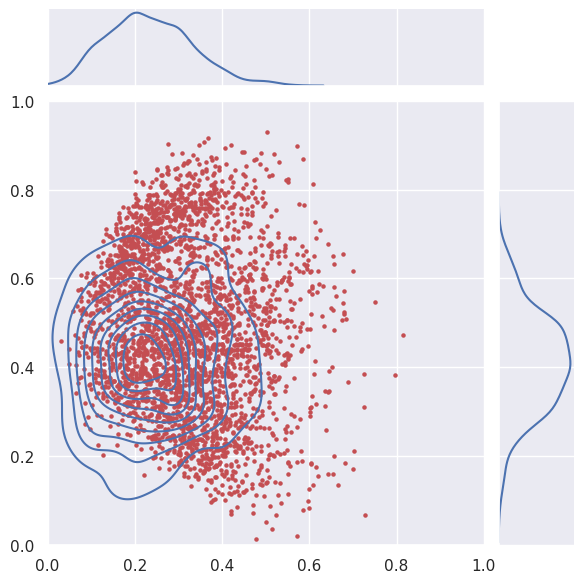

[0.21008892207942592, 0.2972722666940497]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936, 0.31241644784859235, 0.3021608862254486, 0.29875955203617366, 0.28942826339642747, 0.2918612282945407, 0.261017551609719, 0.26740737528522934, 0.3012181833971859, 0.2640297721454003, 0.28747575059309005, 0.2432368613021457, 0.25539607766467354, 0.2542671760386763, 0.2461948157148352, 0.25368059438673785]
Epoch 27 Generated Images


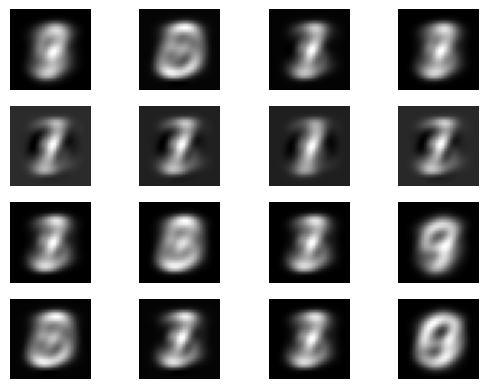

/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)
/tmp/ipykernel_284309/1791456084.py:48: RuntimeWarning: invalid value encountered in scalar divide
  df = df/abs(df)


Generator Loss: 7.962956418951301e-05
Discriminator Loss: inf
--------------------


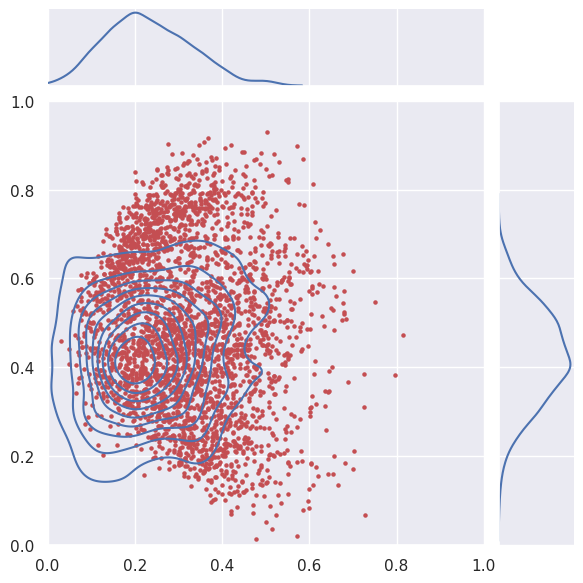

[0.21478483415078395, 0.3210453890018563]
[0.2987821059205121, 0.3842049677921059, 0.400325141490128, 0.4083289540019918, 0.3712485403627153, 0.3730430963563256, 0.3592248749484527, 0.3403505542249102, 0.33154185941138886, 0.3305264297238801, 0.32174645610917274, 0.33778737686258936, 0.31241644784859235, 0.3021608862254486, 0.29875955203617366, 0.28942826339642747, 0.2918612282945407, 0.261017551609719, 0.26740737528522934, 0.3012181833971859, 0.2640297721454003, 0.28747575059309005, 0.2432368613021457, 0.25539607766467354, 0.2542671760386763, 0.2461948157148352, 0.25368059438673785, 0.26791511157632014]
Epoch 28 Generated Images


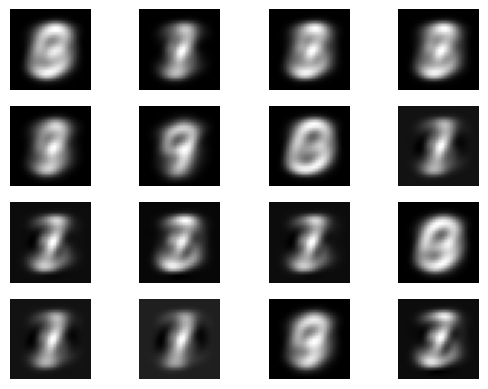

/tmp/ipykernel_284309/2638086283.py:102: RuntimeWarning: divide by zero encountered in log
  return -np.log(1-p)
/tmp/ipykernel_284309/1791456084.py:48: RuntimeWarning: invalid value encountered in scalar divide
  df = df/abs(df)


KeyboardInterrupt: 

In [5]:
q=5 # Set it to dimensionality of data *n 2 +. 1
c=1
tracked_kl_div_1 = []
tracked_kl_div_2 = []
# Initialize a quantum circuit with q qubits, and c cbits
# Initializt Ancilla qubit in equi-superposition
circ = QuantumCircuit(q,c)
circ.h(0)
layer_style = "Controlled-Dual"
train_var = init_random_variables(q-1,layer_style)

# Initial Learning Settings such as alpha etc.
tracked_d_loss = []
gradients = []
learning_rate=0.01
train_iter = 250
tracked_g_loss = []
gradients_g = []
corr = 0
wrong= 0 
loss_d_to_g = 0
loss_d_to_real = 0
tracked_loss_d_to_g = []
tracked_loss_d_to_real = []
train_on_fake = 5
df = [0,0]
print('Starting Training')
print('-'*20)

for epoch in np.arange(1,100):
    par_shift = 0.5*np.pi*np.sqrt(1/(epoch+1))
    # ------------------------------------------------------------------------------------------
    # This section is the discriminator training section
    # Each data point is tested against a random number, of which it decidesa wheter to 
    # Train against discerning between fake or real 
    # This causes "unstable" loss functions, but not very "unstable". Just slightly inconsistent
    # ------------------------------------------------------------------------------------------
    counter = 0
    for _ in range(1):
        for key,value in train_var.items():
            if str(q//2 + 1 ) in key:
                break
            for key_value in range(len(value)):
                forward_diff = cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=True,fwd_diff=True)),1,None)
                backward_diff = cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=True,fwd_diff=False)),1,None)
                df = 0.5*(forward_diff-backward_diff)
                if abs(df)>1:
                    df = df/abs(df)
                #train_var[key][key_value] -= df*learning_rate/10
    for index,point in enumerate(pca_data_rot[:len(pca_data_rot)//10]):
        df = [0,0]
        gradients = []
        loss= [0,0]
        #Training the Discriminator:
        for key,value in train_var.items():
            if str(q//2 + 1) in key:
                break
            for key_value in range(len(value)):
                #TRAIN ON REAL DATA
                # BETIS HERE
                # _________
                forward_diff = cost_function(get_probabilities(disc_real_training_circuit(train_var,point,key,key_value,diff=True,fwd_diff=True)),0,None)
                backward_diff = cost_function(get_probabilities(disc_real_training_circuit(train_var,point,key,key_value,diff=True,fwd_diff=False)),0,None)
                df = 0.5*(forward_diff-backward_diff)
                train_var[key][key_value] -= learning_rate*df
        loss[0] += cost_function(get_probabilities(disc_real_training_circuit(train_var,point,key,key_value,diff=False,fwd_diff=False)),0,None)
        loss[1] += 1
    loss_g = [0,0]
    # ------------------------------------------------------------------------------------------
    # This section is the generator training section
    # The discriminator just looks to fool the state we learnt above 
    # This means that instead of learning 10000 times, we could up the learning rate and just learn a few more times
    # We dont want it to be too large so it spins around the qubits state
    # ------------------------------------------------------------------------------------------
    #Train the generator now as much as we trained the Disc
    for _ in range(len(pca_data_rot)//10):
        gen_params=True
        for key,value in train_var.items():
            if str(q//2 + 1) not in key and gen_params:
                #print(f"{key} is not a GAN parameter")
                continue
            else: 
                gen_params = False
            for key_value in range(len(value)):
                #TRAIN ON FAKE DATA
                forward_diff = generator_cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=True,fwd_diff=True)))
                backward_diff = generator_cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=True,fwd_diff=False)))
                df = 0.5*(forward_diff-backward_diff)
                train_var[key][key_value] -= df*learning_rate*2.5
        loss_g[0] += generator_cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=False,fwd_diff=False)))
        loss_g[1] +=1
    print(f"Generator Loss: {loss_g[0]/loss_g[1]}")
    tracked_g_loss.append(loss_g[0]/loss_g[1])
    loss_qgan = cost_function(get_probabilities(disc_fake_training_circuit(train_var,key,key_value,diff=False,fwd_diff=False)),1,None) 
    t_loss = loss_qgan + (loss[0]/loss[1])
    tracked_loss_d_to_real.append(loss[0]/loss[1])
    tracked_loss_d_to_g.append(loss_qgan)
    print(f"Discriminator Loss: {t_loss}")
    tracked_d_loss.append(t_loss)
    print("-"*20)
    data = []
    circ = disc_fake_training_circuit(train_var,point,key,key_value,Sample=True)
    n_results = q//2
    for _ in range(500):
        job = execute(circ, backend, shots=20)
        results = job.result().get_counts(circ)
        bins = [[0,0] for _ in range(n_results)]
        for key,value in results.items():
            for i in range(n_results):
                if key[-i-1]== '1':
                    bins[i][0] += value
                bins[i][1] += value
        for i,pair in enumerate(bins):
            bins[i]= pair[0]/pair[1]
        data.append(bins)
    data = np.array(data)
    try:
        graph = sns.jointplot(x=data[:,0],y=data[:,1],kind="kde",ylim=(0,1),xlim=(0,1))
        graph.x = pca_data[:,0]
        graph.y = pca_data[:,1]
        graph.plot_joint(plt.scatter, marker='o', c='r', s=5)
        plt.savefig("qgan_ICLR_-epoch-mnist-{}-generated-distribution".format(epoch))
        plt.show()
    except:
        pass
    dim1_kl_div = generate_kl_divergence_hist(pca_data, data)
    print(dim1_kl_div)
    tracked_kl_div_1.append(np.mean(np.array(dim1_kl_div)))
    print(tracked_kl_div_1)
    # For accurate KL Div we need to usue higher shots
    data = []
    for _ in range(16):
        job = execute(circ, backend, shots=20)
        results = job.result().get_counts(circ)
        bins = [[0,0] for _ in range(n_results)]
        for key,value in results.items():
            for i in range(n_results):
                if key[-i-1]== '1':
                    bins[i][0] += value
                bins[i][1] += value
        for i,pair in enumerate(bins):
            bins[i]= pair[0]/pair[1]
        data.append(bins)
    data = np.array(data)
    new_info = descale_points(data[:16])
    new_info = new_info.reshape(new_info.shape[0],28,28)
    print(f"Epoch {epoch} Generated Images")
    for i in range(new_info.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(new_info[i, :, :], cmap='gray')
        plt.axis('off')
    plt.savefig("qgan_ICLR_-epoch-mnist-{}-generated-images".format(epoch))
    plt.show()
    with open('new_qgan_results_mnis_epoch_ICLR_{}.txt'.format(epoch), 'w') as file:
        file.write("Tracked KL Divergence\n")
        file.write(str(tracked_kl_div_1)+"\n")
        file.write("Loss Of Generator\n")
        file.write(str(tracked_g_loss)+"\n")
        file.write("Loss Of Discriminator\n")
        file.write(str(tracked_d_loss)+"\n")
    save_variables(train_var,epoch)